# Coursework 2: Learning with Images
_COMP0169 Team_

__Niloy J. Mitra & Tobias Ritschel__

TAs:  __Luca Morreale, Pradyumna Reddy, Sanjeev Muralikrishnan & Animesh Karnewar__

The total points for this exercise are 100.

Please refer to Moodle submission page for the due date.


# Submission:

Coursework submissions must comprise of this **single** jupyter notebook, containing your code and written comments. Cells that need to be changed are clearly stated with a &#9998; symbol and you are not allowed to change the rest of the code in any ways. Descriptive answers must be contained in the markdown blocks starting with "_Your reply_:". Code must only be written in the space inside the `#solution ... #end_solution` blocks. Code written outside these blocks will not be processed or evaluated. However, feel free to change and experiment with various hyperparameters.

Note that only the imported packages are allowed to be used. 

In case you are suspected of plagiarism you might be requested to present your work in a one-to-one session (date to be decided) demonstrating what you have implemented.

**Questions:**

[Question 1](#question1): Image, audio; all the same (20 points)

[Question 2](#question2): Denoising (35 points)

[Question 3](#question3): Auto-encoder and Variational AutoEncoder (45 points)

## Datasets

All the datasets must be contained in the `Datasets` folder at the same level of the notebook.
In this courswork you are going to use MNIST, CelebA-HQ, audio data and noisy images. Each dataset is used in a specific exercise. The data paths are already present in the code, please **do not** change them.

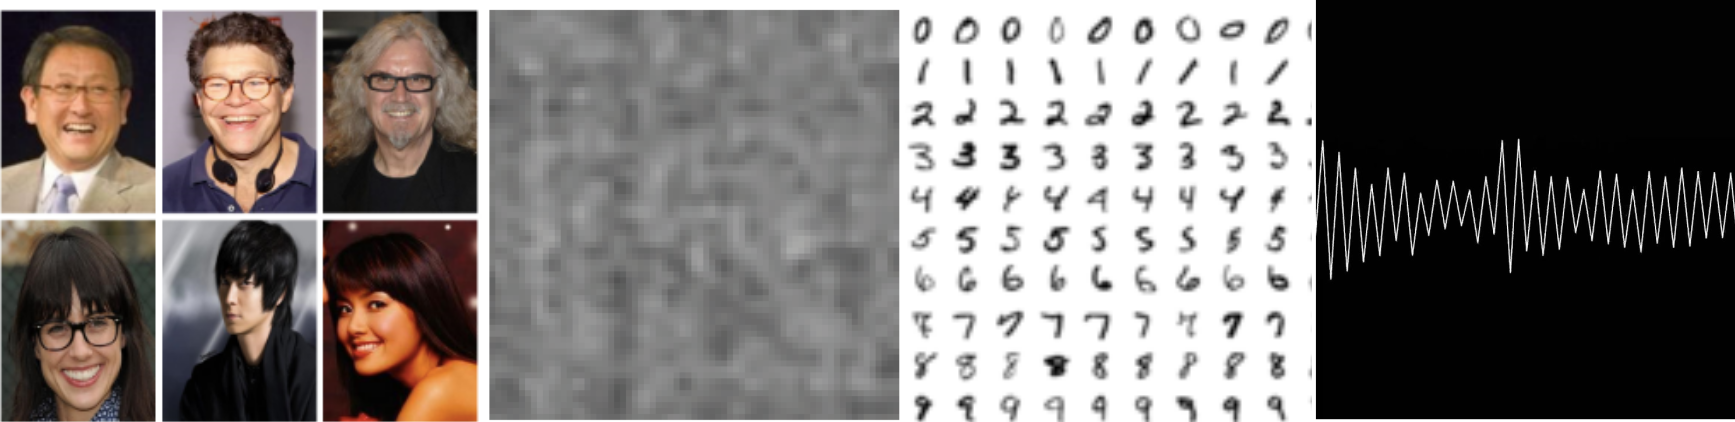

## Trained Models zip for marking

Once you are done with the assignment, create a zip file of your trained models and share an storage link the below cell:

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply_:

## Packages

The following cell imports all packages needed in the coursework. You are not allowed to use any other packages than the ones listed below.
<a name='packages'></a>

In [1]:
import IPython
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Module
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
from skimage.metrics import peak_signal_noise_ratio
import os
from pathlib import Path
import torchvision
import PIL
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import torchvision.transforms.functional as TF
import scipy
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from scipy.io.wavfile import read

In [2]:
# install prettytable and uncomment to use count_paramters function
from prettytable import PrettyTable

In [3]:
# install livelossplot and uncomment below to plot losses live (while training) <- highly suggested
from livelossplot import PlotLosses

In [4]:
# If using collab, uncomment the lines below and temporarily modify the paths in the notebook appropriately
# And revert the paths to what they were while submitting.
# from google.colab import drive
# drive.mount('/content/drive')

Set random seed

In [4]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

Set device

In [5]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


Create folders for 1. saving models and 2. saving visual logs.

In [6]:
models_dir = Path("./models")
logs_dir = Path("./logs")

models_dir.mkdir(parents=True, exist_ok=True)
logs_dir.mkdir(parents=True, exist_ok=True)

### Utility functions

In [7]:
def plot_images(images, titles, texts):
    N_cols = len(images)
    N_rows = len(images[0])
    
    fig, axs = plt.subplots(N_rows, N_cols, figsize=(20, 15))
    
    if titles is not None:
        for i, ax in enumerate(axs[0]):
            ax.set_title(titles[i])
    
    for i, img_col in enumerate(images):
        for j, img in enumerate(img_col):
            if len(img.shape) == 2:
                axs[j,i].imshow(img, interpolation='nearest', cmap='gray')
            else:
                axs[j,i].imshow(img, interpolation='nearest')
            axs[j,i].axis('off')
            if texts is not None:
                axs[j,i].text(0.5,-0.1, str(texts[j][i])[:4], size=10, ha="center", transform=axs[j,i].transAxes)
    plt.show()

def l1_loss(x, y):
    return np.mean(np.abs(x-y))

def count_parameters(model):
    # you can use this function to print number parameters per layer
    # install prettytable and uncomment import to use count_paramters function
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

def plot_fftfreq(frequency, amplitude_before_filtering, amplitude_after_filtering=None): 
    plt.figure(figsize=(20,5))
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency")
    plt.plot(frequency, np.abs(amplitude_before_filtering), label='before')
    
    if type(amplitude_after_filtering) != type(None):
        plt.plot(frequency, np.abs(amplitude_after_filtering), label='after')
    
    plt.legend()
    plt.show()

def plot_waveform(input_audio, filtered_audio):
    plt.figure(figsize=(20,5))
    plt.title("Input (red) and Output (green)")
    plt.plot(input_audio, c='r', label='input')
    plt.plot(filtered_audio, c='g', label='output')
    plt.show()

def plot_images_horizontal(imgs):
    num_imgs = len(imgs)
    f = plt.figure(figsize=(40, 15))
    for i in range(num_imgs):
        f.add_subplot(1, num_imgs, i+1)
        plt.imshow(imgs[i])
    plt.show()

## 1. Image, audio; all the same (20 points)
<a name='question1'></a>

[a)](#question1a) Implement a filter to remove low temporal frequencies from the audio file `audio_clip.wav`, provided under `Datasets/Filtering/` (loading code is already provided). Implement a version using FFT (`highpass_fft_filter_audio`)(**2 points**) and a version using moving average (`highpass_normal_filter_audio`) (**2 points**), discuss which version, when and why is better (**1 points**).

[b)](#question1b) Implement a filter to find vertical edges in an image. We provide a sample file `image.png` under
`Datasets/Filtering/` for testing. Apply your filter to this image. (**8 points**) Implement the filter without for loops (**2 points**).

[c)](#question1c) Implement a function to modify an image such that the modified image is visually different from the original but has the same output as the original when you perform edge detection.(**5 points**).

(Reference example: One of the changes that we implemented yields an L1 distance of 84.993 between the original image and the modified image, while has 0.0 L1 distance between the filtered outputs of both.)

**Question 1.a**
<a name='question1a'></a>

Implement a filter to remove low temporal frequencies

<font color='red'>Hint:</font> use "fft", "fftfreq" functions from "np.fft".


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def highpass_fft_filter_audio(audio):
    #solution

    #end_solution
    return filtered_audio, frequencies, amplitude_before_filtering, amplitude_after_filtering

In [ ]:
def highpass_normal_filter_audio(audio):
    filtered_audio = None
    #solution

    #end_solution
    return filtered_audio

Load  audio from file

In [8]:
# load input_audio from input_audio_filename
input_audio_filename = "./Datasets/Filtering/audio_clip.wav"
audio_rate, input_audio = scipy.io.wavfile.read(input_audio_filename)
print(f"Audio array shape: {input_audio.shape}")
print(f"Since the audio clip contains stereo (2) channels, we only use the first one")
input_audio = input_audio[:, 0]
print(f"Input audio shape: {input_audio.shape}")

IPython.display.Audio(input_audio, rate=audio_rate)

Audio array shape: (90000, 2)
Since the audio clip contains stereo (2) channels, we only use the first one
Input audio shape: (90000,)


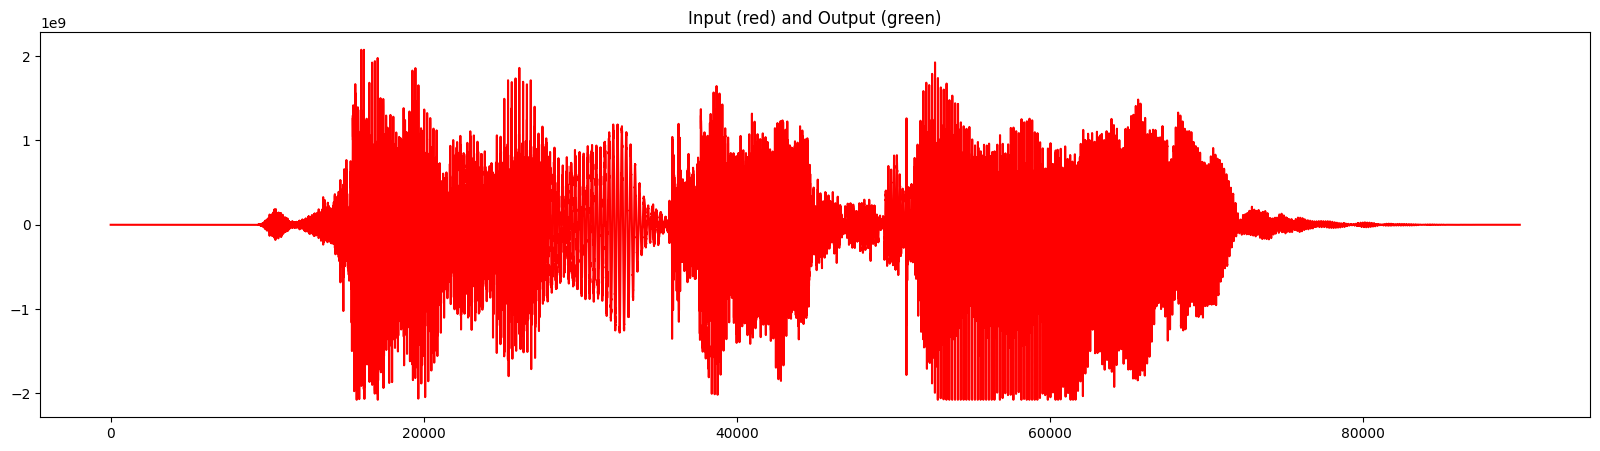

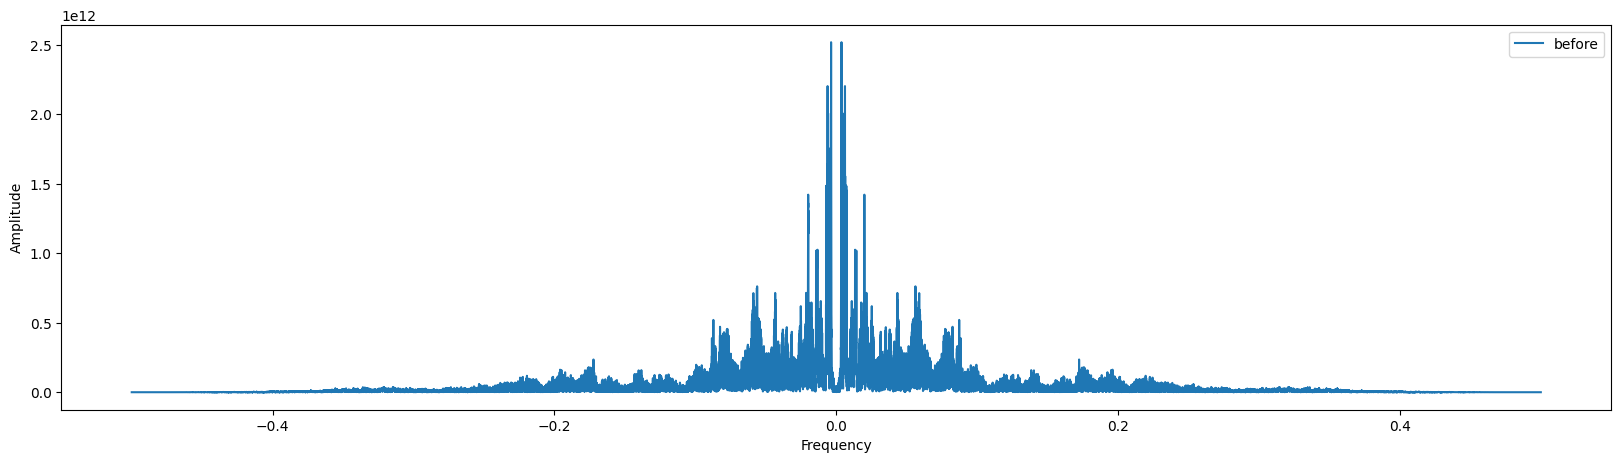

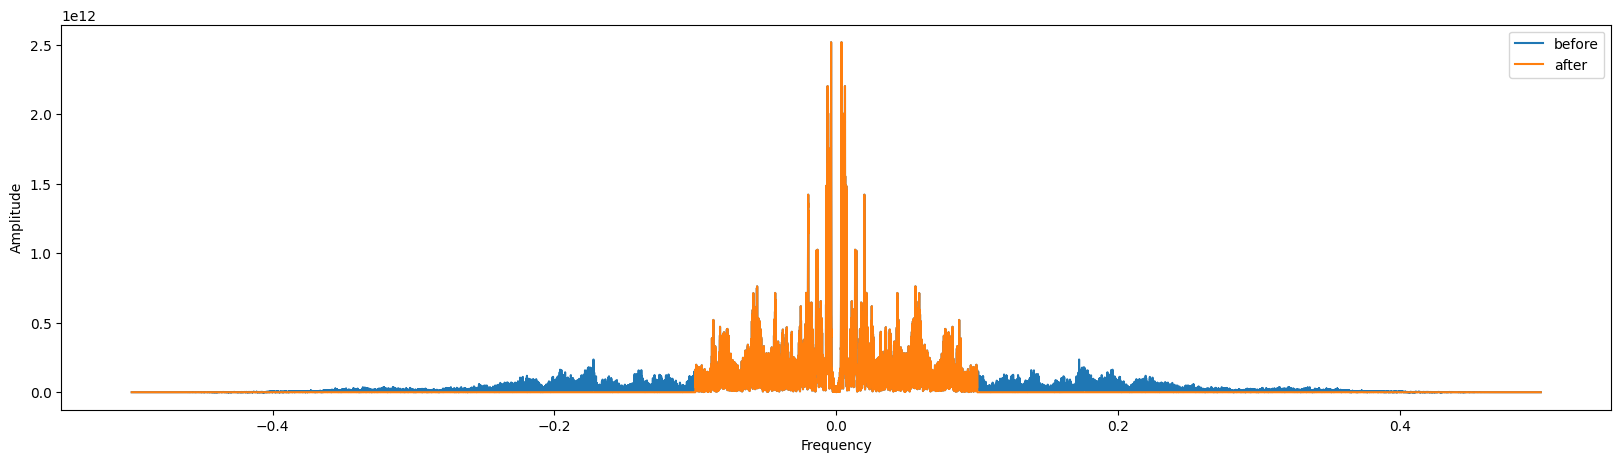

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


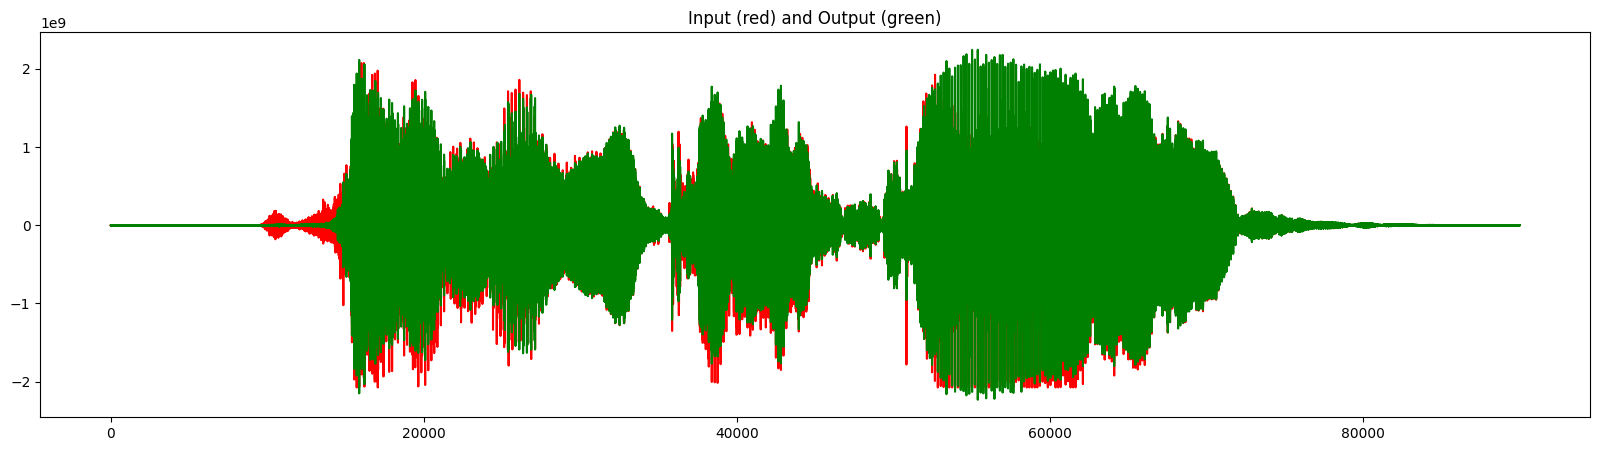

/Users/lucien/Library/Python/3.9/lib/python/site-packages/IPython/lib/display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [31]:
r = np.fft.fft(input_audio)
ab = np.absolute(r)
idx = np.where(ab < 0.01)
y = np.fft.fftfreq(input_audio.shape[0])
z = np.fft.fftshift(y)
q = np.fft.fftshift(r)
x = idx
plot_waveform(input_audio, [])
plot_fftfreq(z, q, None)
th = 0.1
fq = np.copy(q)
fq[(z > th)|(z < -th)] = 0
plot_fftfreq(z, q, fq)
fqa = np.fft.ifft(fq)
plot_waveform(input_audio, fqa)
IPython.display.Audio(fqa, rate=audio_rate)

Run filtering with input data 

In [ ]:
#begin_test
filtered_audio, frequencies, amplitude_before_filtering, amplitude_after_filtering = highpass_fft_filter_audio(input_audio)
plot_fftfreq(frequencies, amplitude_before_filtering, amplitude_after_filtering)
plot_waveform(input_audio, filtered_audio)
#end_test

In [ ]:
print("Original audio")
IPython.display.Audio(input_audio, rate=audio_rate)

In [ ]:
print("Filtered audio")
IPython.display.Audio(filtered_audio, rate=audio_rate)

In [ ]:
#begin_test
filtered_audio = highpass_normal_filter_audio(input_audio)
plot_waveform(input_audio, filtered_audio)

# plotting fft representation of the filtered signal
_, frequencies_normal, amplitude_before_filtering_normal, _ = highpass_fft_filter_audio(filtered_audio)
plot_fftfreq(frequencies_normal, amplitude_before_filtering, amplitude_before_filtering_normal)
#end_test

In [ ]:
#begin_test
#end_test

In [ ]:
print("Original audio")
IPython.display.Audio(input_audio, rate=audio_rate)

In [ ]:
print("Filtered audio")
IPython.display.Audio(filtered_audio, rate=audio_rate)

Discuss which version is better when and why? 

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply_:

**Question 1.b**
<a name='question1b'></a>

Implement a filter to find vertical edges in an image

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def detect_vertical_edges(image):
    #solution

    #end_solution

    return filtered_image

In [ ]:
input_image_filename = "./Datasets/Filtering/image.png"

Run filter over the input image

In [ ]:
#begin_test
input_image = np.asarray(PIL.Image.open(input_image_filename).convert('RGB'))
filtered_image = detect_vertical_edges(input_image)
plot_images_horizontal([input_image, filtered_image])
#end_test

In [ ]:
#begin_test
#end_test

**Question 1.c**
<a name='question1c'></a>

Modify the input image such that it is visually different from the original but has the same output when you perform edge detection. Ideal value for L1_loss between filtered_image and filtered_modified_image is 0.0, but your modification can/should try to minimize this distance as much as possible.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def modify_image(input_image):
    #solution

    #end_solution

    return input_modified

In [ ]:
#begin_test
input_modified = modify_image(input_image)
filtered_modified_image = detect_vertical_edges(input_modified)
plot_images_horizontal([input_modified, filtered_modified_image])
print(f"L1 distance between original and modified image: {l1_loss(input_image, input_modified)}")
print(f"L1 distance between filtered and modified filtered image: {l1_loss(filtered_image, filtered_modified_image)}")
#end_test

In [ ]:
#begin_test
#end_test

## 2. Denoising (35 points)
<a name='question2'></a>

[a)](#question2a) Implement `denoiseGauss(image)` to denoise the image noisy `image.png` under `Filtering/` using a
5×5 Gaussian filter. (**5 points**)

[b)](#question2b) Implement a pyramidal encoder-decoder to denoise an image. We provide you pairs of noisy and
noise-free image patches of size 128×128 for training and testing, under `Datasets/Denoising/`. You may use all the infrastructure of `Pytorch`. The encoder and decoder must have at least 3 layers each. Please use ReLU non-linearities after each layer (**15 points**).
Please train for no more than 400 epochs.

[c)](#question2c) Given the comparison between the Gaussian-kernel denoising and encoder-decoder denoising
methods, discuss which method performs better and where. You should write no more than half a page. (**5 points**)

[d)](#question2d) Modify the first noisy image from the training set such that it follows the distribution of the domain data (i.e. looks like the noisy images from the training set), but when passed through the trained AE denoiser, yields poor PSNR which is comparable to the gaussian denoiser's performance (**8 points**). Explain your approach in brief (**2 points**). Write no more than 8 sentences.

(Reference example: Given a random noisy image X sampled from our dataset the PSNR value of the output of the trained denoising network on X was 22db we were able to estimate an adverserial example X_adv whose MSE with X is 0.0023 and 0.0043 for two different runs, the outputs of denoising X_adv with the same network have a PSNR of 16.69db and 14.91db respectively.)


**Question 2.a**
<a name='question2a'></a>

Implement the function to denoise the image

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def gkern(l=5, sig=1.):
    
    #solution

    #end_solution

    
    return out_kernel

def denoise_gauss(image):
    
    #solution

    #end_solution

    
    return denoised_image

Load input image from file

In [ ]:
noisy_image_filename = "./Datasets/Filtering/noisy_image.png"

Filter the input image

In [ ]:
noisy_image = np.asarray(PIL.Image.open(noisy_image_filename).convert('RGB'))
denoised_image = denoise_gauss(noisy_image)
plot_images_horizontal([noisy_image, denoised_image])

**Question 2.b**
<a name='question2b'></a>

Implement dataset class below. Note that the images output by the `DenoisingDB` dataset should be of size 128 x 128. Crop the original images at the top left corner to get the aforementioned size.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class DenoisingDB(Dataset):
    
    def __init__(self, input_imgs_path, cleaned_imgs_path):
        super().__init__()
        
        #solution

        #end_solution


    def __len__(self):
        
        #solution

        #end_solution

        
        return length

    def __getitem__(self, idx):
        
        #solution

        #end_solution

        
        return (input_image, target_image)

Implement the Encoder network:

Note that the `Encoder` and `Decoder` networks need to be sufficiently large for performing the denoising task successfully. We suggest 5 levels and double the number of internal feature-maps when reducing the spatial resolution with use of ReLU non-linearities. But feel free experiment with different layers, blocks and operations.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class Encoder(Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        
        #solution

        #end_solution


    def forward(self,high_res_image):
        
        #solution

        #end_solution

        
        return low_res_image

Implement the Decoder network:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class Decoder(Module):

    def __init__(self):
        super(Decoder, self).__init__()
        
        #solution

        #end_solution


    def forward(self, low_res_image):
        
        #solution

        #end_solution

        
        return denoised_image

Implement the reconstruction loss

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def loss_function(prediction, target):
    
    #solution

    #end_solution

    
    return loss

Paths to input data

In [ ]:
input_imgs_path = Path("./Datasets/Denoising/input_noisy_images")
cleaned_imgs_path = Path("./Datasets/Denoising/target_clean_images")

Write the training loop

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
docs_dataset = DenoisingDB(input_imgs_path, cleaned_imgs_path)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

#solution

#end_solution



Save the model (needed for marking)

In [ ]:
torch.save({"encoder":encoder, "decoder":decoder}, "models/ex2b.pth")

Load trained model

In [ ]:
state_dict = torch.load("models/ex2b.pth")
encoder = state_dict["encoder"].to(device)
decoder = state_dict["decoder"].to(device)

Plot 5 input images and their relative denoised images side by side.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
input_imgs, gt_imgs, output_imgs = [], [], []
#solution

#end_solution

titles = ['Input', 'GroundTruth', 'Output']
plot_images([input_imgs, gt_imgs, output_imgs], titles, None)


**Question 2.c**
<a name='question2c'></a>

Compute images for both the AE and Gaussian Kernels algorithm from `images`.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
dataset = DenoisingDB(input_imgs_path,cleaned_imgs_path)

images = [docs_dataset[i][0].to(device) for i in range(5)]
targets = [docs_dataset[i][1].to(device) for i in range(5)]
images_ae = []
images_gauss = []

# your solution should populate the `images_ae` and `images_gauss` lists with the required 5 image outputs
#solution

#end_solution



In [ ]:
# Plot images and PSNR
imgs_plot = [ el.detach().squeeze().cpu().numpy() for el in images]
tgts_plot = [ el.detach().squeeze().cpu().numpy() for el in targets]

In [ ]:
psnrs = [ 0.0 for el in targets ]
for i in range(len(tgts_plot)):
    psnr_ae    = peak_signal_noise_ratio(tgts_plot[i], images_ae[i])
    pnsr_gauss = peak_signal_noise_ratio(tgts_plot[i], images_gauss[i])
    psnrs[i] = ['', psnr_ae, pnsr_gauss, '']

img = [imgs_plot, images_ae, images_gauss, tgts_plot]
titles = ['Input', 'AE', 'Gaussian', 'Targets']
texts = psnrs
plot_images(img, titles, texts)
plt.show()

Discuss which method performs better:

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply_:

**Question 2.d**
<a name='question2d'></a>

Use the cell below to modify the `adversarial_image` variable: 

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
adversarial_image = torch.stack(images, dim=0).to(device)[-1:]
adversarial_target = torch.stack(targets, dim=0).to(device)[-1:]

# Your solution should update (modify) the `adversarial_image` variable above.
# After modification, it should still be torch.Tensor of shape [1 x 1 x 128 x 128]
#solution

#end_solution


Compute the performance of the `adversarial` image on AE denoiser and Gaussian-kernel denoiser

In [ ]:
original_image = torch.stack(images, dim=0).to(device)[-1:]
ae_prediction = decoder(encoder(adversarial_image))
ae_out = ae_prediction.permute(0, 2, 3, 1).detach().cpu().squeeze().numpy()

image_np = image.squeeze().cpu().numpy()
image_np = np.tile(image_np[:,:,None], (1,1,3))
gauss_out = denoise_gauss(image_np)[:,:,0]

adv_img = adversarial_image[0].permute(1, 2, 0).cpu().numpy()
target = adversarial_target[0].permute(1, 2, 0).cpu().numpy()

psnr_ae = peak_signal_noise_ratio(adversarial_target[0, 0].cpu().numpy(), ae_out)
psnr_gauss = peak_signal_noise_ratio(adversarial_target[0, 0].cpu().numpy(), gauss_out)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))
ax1.set_title("Modified image")
ax1.imshow(adv_img, cmap="gray") 
ax2.set_title(f"AE output PSNR: {psnr_ae :.2f}")
ax2.imshow(ae_out, cmap="gray") 
ax3.set_title(f"Gaussian output PSNR: {psnr_gauss :.2f}")
ax3.imshow(gauss_out, cmap="gray") 
ax4.set_title("Target")
ax4.imshow(target, cmap="gray") 

plt.tight_layout()
plt.show()
print('MSE between original and adversarial image: ', ((original_image-adversarial_image)**2).mean())

Explain your approach below:

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply_:

## 3. Auto-encoder and Variational Auto-encoder (45 points)
<a name='question3'></a>

[a)](#question3a) Implement a convolutional auto-encoder (AE). You can make use of convolution, pooling, batchnorm layers (feel free to use any differentiable operations that `PyTorch` provides). Implement Dataset classes for loading the MNIST and CelebA-HQ dataset. And implement the loss function. The loss between input and output should be **L2**. (**15 points**) $$||I −dec(enc(I))||^2_2$$

[b)](#question3b) Train your defined AE on MNIST dataset. Please train for no more than 100 epochs. (**5 points**)
Test its reconstruction performance on random 5 samples of the validation split by showing the input and the AE reconstruction, side-by-side.

[c)](#question3c) Train your defined AE on CelebAHQ dataset. Please train for no more than 400 epochs. (**5 points**) Test its reconstruction performance on random 5 samples of the validation split by showing the input and the AE reconstruction, side-by-side.

[d)](#question3d) Implement a Variational Auto-Encoder (VAE) and train it on CelebA-HQ. Implement the VAE ELBO (Evidence Lower Bound) loss. Show 10 random images sampled from the VAE you trained. (**10 points**)
Please train it for no longer than 400 epochs.

[e)](#question3e) i. Compare the reconstruction performance of AE v/s VAE by plotting reconstructions (i.e. G.T | A.E. reconstruction | VAE reconstruction) side by side for 5 samples from the validation split of CelebA-HQ dataset (**1 point**). ii. Compare the generative performance of AE v/s VAE by randomly sampling 5 samples from the latent space of the AE and the VAE and plotting them side by side. Note: You need to do independent research and implement a mechanism to sample from the bottleneck space of the AE reasonably 🤔. (**4 points**).

[f)](#question3f) Discuss your design choices for Q3a and Q3d (i.e. AE and VAE). Are the models different? Why? Discuss in no more than 10 sentences. If needed add plots and a demo. (**5 points**)

**Question 3.a**
<a name='question3a'></a>

Implement a convolutional auto-encoder

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class AutoEncoder(Module):
    
    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        
        #solution

        #end_solution

    
    def encoder(self,image):
        
        #solution

        #end_solution

        
        return code
    
    def decoder(self,code):
        
        #solution

        #end_solution

        
        return decoded_image
    
    def forward(self,image):
        
        #solution

        #end_solution

        
        return decoded_image

In [ ]:
#begin_test

#end_test

**Question 3.b**
<a name='question3b'></a>

Implement the dataset class to load MNIST

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class MNIST(Dataset):
    
    def __init__(self, dataset_path):
        #solution

        #end_solution


    def __len__(self):
        #solution

        #end_solution

        
        return length

    def __getitem__(self, idx):
        #solution

        #end_solution

        
        return image

Implement the dataset class to load CelebAHQ dataset. Feel free to resize the images to a lower resolution depending on your access to compute. Do not resize to a resolution of lower than [32 x 32].

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class CelebAHQ(Dataset):
    
    def __init__(self, dataset_path):
        #solution

        #end_solution


    def __len__(self):
        #solution

        #end_solution

        
        return length

    def __getitem__(self, idx):
        #solution

        #end_solution

        
        return image

Implement the reconstruction loss

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def reconstruction_loss(prediction, target):
    
    #solution

    #end_solution

    
    return recon_loss

Create MNIST dataloaders for training and validation

In [ ]:
mnist_train_data_path = Path("./Datasets/MNIST/train/")
mnist_train_dataset = MNIST(mnist_train_data_path)

mnist_validation_data_path = Path("./Datasets/MNIST/val/")
mnist_validation_dataset = MNIST(mnist_validation_data_path)

Create CelebA-HQ dataloaders for training and validation

In [ ]:
celeba_hq_train_data_path = "./Datasets/celeba_hq_256/train"
celeba_hq_train_dataset = CelebAHQ(celeba_hq_train_data_path)

celeba_hq_validation_data_path = "./Datasets/celeba_hq_256/val"
celeba_hq_validation_dataset = CelebAHQ(celeba_hq_validation_data_path)

Train the AE on MNIST

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
mnist_autoencoder = None # your model (re-assign below in solution part)
# YOU CAN CHOOSE YOUR BATCH SIZE (You can edit just the batch size)
torch_train_mnist = DataLoader(mnist_train_dataset,shuffle=True,batch_size=128,num_workers=1)
torch_validation_mnist = DataLoader(mnist_validation_dataset,shuffle=True,batch_size=128,num_workers=1)
mnist_optimizer = None # your optimizer (re-assign below in solution part)

liveloss = PlotLosses() # utility that you can optionally use to view losses live during training

#solution

#end_solution


Save trained model (needed for marking)

In [ ]:
torch.save(mnist_autoencoder, "models/ex3b.pth")

Load trained model

In [ ]:
mnist_autoencoder = torch.load("models/ex3b.pth")

Showing, for 5 samples in the validation set, the input and the AE reconstruction, side-by-side.

In [ ]:
indices = np.random.choice(range(len(mnist_validation_dataset)), 5, replace=False)
mnist_random_images = [mnist_validation_dataset[idx] for idx in indices]
batch = torch.stack(mnist_random_images, dim=0)
gt_img = batch.to(device)

# run the autoencoder:
mnist_autoencoder.eval()
pred_img = mnist_autoencoder(gt_img)

# plot the images:
imgs_plot = [ el.cpu().squeeze().numpy() for el in gt_img]
pred_plot = [ el.cpu().detach().squeeze().numpy() for el in pred_img]

plot_images([imgs_plot, pred_plot], ["Input", "AE reconstruction"], None)
plt.show()
plt.close()

**Question 3.c**
<a name='question3c'></a>

Feel free to use the cell below to redefine (copy + edit) the AutoEncoder class if you are changing the architecture of your AutoEncoder Model for CelebA-HQ dataset.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
#solution

#end_solution


Train the autoencoder on CelebA-HQ dataset

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
celeba_hq_autoencoder = None # your model (assign below)
# YOU CAN CHOOSE YOUR BATCH SIZE (You can edit just the batch size)
torch_train_celeba_hq = DataLoader(celeba_hq_train_dataset, shuffle=True, batch_size=128, num_workers=1)
torch_validation_celeba_hq = DataLoader(celeba_hq_validation_dataset, shuffle=True, batch_size=128, num_workers=1)
celeba_hq_optimizer = None # your optimizer (re-assign below in solution part)

liveloss = PlotLosses() # utility that you can optionally use to view losses live during training

#solution

#end_solution


Save the trained model (Needed for marking)

In [ ]:
torch.save(celeba_hq_autoencoder, "models/ex3c.pth")

Load the trained model

In [ ]:
celeba_hq_autoencoder = torch.load("models/ex3c.pth")

Showing for 5 samples in the validation set, the input and AE reconstruction, side-by-side.

In [ ]:
indices = np.random.choice(range(len(celeba_hq_validation_dataset)), 5, replace=False)
celeba_hq_random_images = [celeba_hq_validation_dataset[idx] for idx in indices]
batch = torch.stack(celeba_hq_random_images, dim=0)
gt_img = batch.to(device)

# run the autoencoder:
celeba_hq_autoencoder.eval()
pred_img = celeba_hq_autoencoder(gt_img)

# plot the images:
imgs_plot = [ el.cpu().permute(1, 2, 0).numpy() for el in gt_img]
pred_plot = [ el.cpu().detach().permute(1, 2, 0).numpy() for el in pred_img]

plot_images([imgs_plot, pred_plot], ["Input", "AE reconstruction"], None)
plt.show()
plt.close()

**Question 3.d**
<a name='question3d'></a>

Create the VAE class

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class VAE(Module):

    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        self.channel_size    = channel_size
        
        
        #solution

        #end_solution

    
    def encoder(self,image):
        
        #solution

        #end_solution

        
        return mu, std
    
    def reparametrization_trick(self,mu,std):
        
        #solution

        #end_solution

        
        return z
    
    def decoder(self,code):
        #solution

        #end_solution

        
        return decoded_image
    
    def forward(self, image):
        
        #solution

        #end_solution

        
        return decoded_image, mu, std

In [ ]:
#begin_test

#end_test

Implement your vae losses below

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def reconstruction_loss(prediction, target):
    
    #solution

    #end_solution

    
    return recon_loss

def kl_divergence_loss(mu,std):
    
    #solution

    #end_solution

    
    return kl_loss

Train your VAE

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
celeba_hq_vae = None # your model (assign it below)
# YOU CAN CHOOSE YOUR BATCH SIZE (You can edit just the batch size)
torch_train_celeba_hq = DataLoader(celeba_hq_train_dataset, shuffle=True, batch_size=128, num_workers=1)
torch_validation_celeba_hq = DataLoader(celeba_hq_validation_dataset, shuffle=True, batch_size=128, num_workers=1)
celeba_hq_vae_optimizer = None # your optimizer (re-assign below in solution part)

liveloss = PlotLosses() # utility that you can optionally use to view losses live during training


#solution

#end_solution


Save model (needed for marking)

In [ ]:
torch.save(celeba_hq_vae, "models/ex3d.pth")

Load pretrained model

In [ ]:
celeba_hq_vae = torch.load("models/ex3d.pth")

Reconstructions of the VAE model 5 samples from the validation dataset. Note we use the latent-code means for decoding the reconstruction.

In [ ]:
indices = np.random.choice(range(len(celeba_hq_validation_dataset)), 5, replace=False)
celeba_random_images = [celeba_hq_validation_dataset[idx] for idx in indices]


batch = torch.stack(celeba_random_images, dim=0)
gt_img = batch.to(device)

celeba_hq_vae.eval()
pred_img = celeba_hq_vae(gt_img)[0].permute(0,2,3,1)

imgs_plot = [ el.cpu().squeeze().numpy() for el in gt_img.permute(0,2,3,1)]
pred_plot = [ el.cpu().detach().squeeze().numpy() for el in pred_img]
img = [imgs_plot, pred_plot, ]
plot_images(img, None, None)
plt.show()
plt.close()

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Show 10 Random samples drawn from the trained CelebA-HQ VAE. You can use the `plot_images` function provided to you.

In [ ]:
number_of_samples = 10


#solution

#end_solution


**Question 3.e**
<a name='question3e'></a>

i. Compare the reconstruction performance of AE v/s VAE by plotting reconstructions (i.e. G.T | A.E. reconstruction | VAE reconstruction) side by side for 5 samples from the validation split of CelebA-HQ.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
#solution

#end_solution


ii. Compare the quality of generations by randomly sampling 5 samples from the latent space of the AE and the VAE and plotting them side by side. 
**Note: Do independent research and use appropriate mechanism to sample from the bottleneck space of the AE.**

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
#solution

#end_solution


**Question 3.f**
<a name='question3f'></a>

In your own words, describe your design choices for Q3a. and Q3d. This can include:
1. The architectures you used for the Encoder and Decoder in both
2. The hyperparams used for training, etc.

Explain how and why the models are different? Write no more than 15 sentences and feel free to use figures/plots/math(latex) for explanation.

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 